# Reads Assignment

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.filters import threshold_otsu, threshold_yen, gaussian
from skimage.measure import regionprops
from skimage.morphology import binary_dilation, disk
from skimage.segmentation import watershed
import scipy.ndimage as ndi
from anndata import AnnData
from tifffile import imread, imwrite
from tqdm import tqdm
import matplotlib.pyplot as plt

## Input

In [2]:
# IO path 
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/'
out_path = os.path.join(base_path, 'expr')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
image_path = os.path.join(base_path, 'images/stitching')
sample_dirs = sorted([d for d in os.listdir(image_path) if d.startswith("Sample")])
sample_dirs

['Sample1',
 'Sample2',
 'Sample3',
 'Sample4',
 'Sample5',
 'Sample6',
 'Sample7',
 'Sample8']

## Run pipeline for individual sample

In [173]:
# Iterate through each sample dir
current_sample = sample_dirs[7]
protocol = 'RIBOmap'

print(f"Current sample: {current_sample}")

# Load reads 
current_reads_df = pd.read_csv(os.path.join(image_path, current_sample, 'merged_goodPoints_max3d.csv'))
current_reads_df['x'] = current_reads_df['x'] - 1
current_reads_df['y'] = current_reads_df['y'] - 1
current_reads_df['z'] = current_reads_df['z'] - 1
current_reads_df

Current sample: Sample8


,x,y,z,Gene
0,3751,279,1,Galr1
1,3766,162,1,Olfr741
2,3766,452,0,Npy1r
3,3858,220,1,Pdf
4,3890,440,0,Gipr
...,...,...,...,...
1953602,12888,14459,48,Ankfn1
1953603,13068,14616,50,Ghrh
1953604,13059,14592,52,Ush2a
1953605,12809,14744,53,Pax2


100%|██████████| 12294/12294 [00:01<00:00, 11384.90it/s]


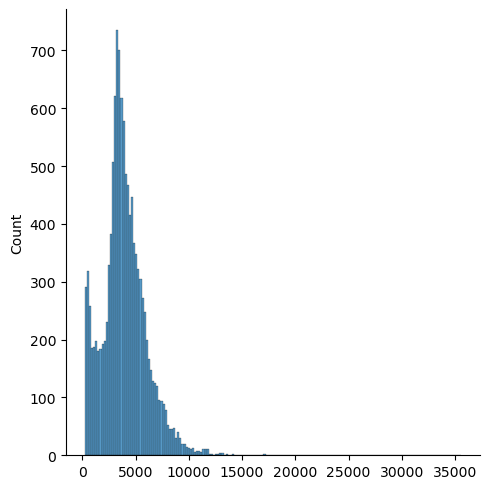

In [174]:
# Load overlay image 
overlay = imread(os.path.join(image_path, current_sample, 'overlay.tif'))
overlay.shape

# Load dapi label
dapi = imread(os.path.join(image_path, current_sample, 'DAPI_label.tif'))
dapi.shape

# Get cell locations 
centroids = []
areas = []

for i, region in enumerate(tqdm(regionprops(dapi))):
    centroids.append(region.centroid)
    areas.append(region.area)

centroids = np.array(centroids)
areas = np.array(areas)
sns.displot(areas)

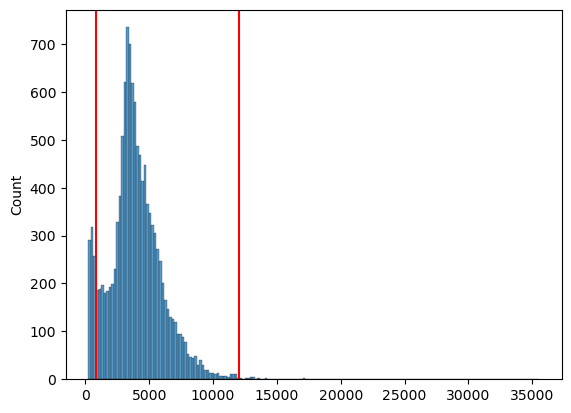

In [175]:
# Filter nuclei by area
lower_bd = 800
upper_bd = 12000

# plot threshold
fig, ax = plt.subplots()
sns.histplot(areas)
ax.axvline(lower_bd, c='r')
ax.axvline(upper_bd, c='r')

# plt.savefig(os.path.join(fig_path, 'reads_filtering_threshold.pdf'))
plt.show()

In [176]:
to_keep = (areas >= lower_bd) & (areas <= upper_bd)
centroids = centroids[to_keep, :]
centroids.shape

(11428, 2)

## Segmentation

Gaussian & Thresholding
Assigning markers
Watershed
Labeled 11326 cells
Saving files to /home/unix/jiahao/wanglab/Data/Analyzed/2023-09-19-wendyw-WW_SC_005/images/stitching
CPU times: user 2min 9s, sys: 2.77 s, total: 2min 12s
Wall time: 2min 17s


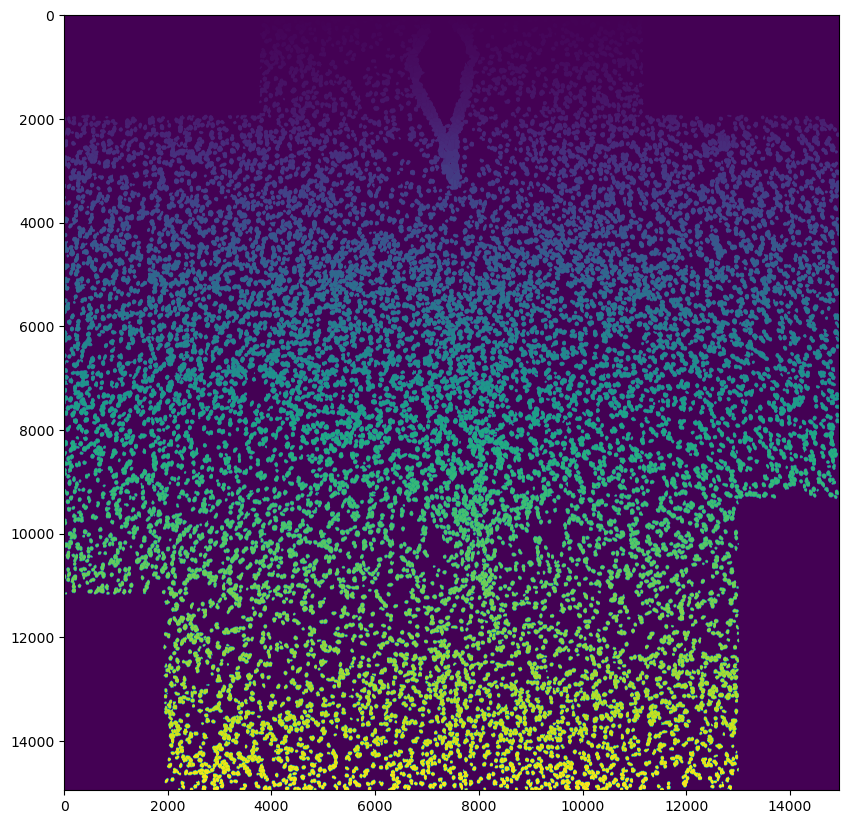

In [177]:
%%time
# Segmentation

print("Gaussian & Thresholding")
overlay_blurred = gaussian(overlay, 5)
threhold = threshold_otsu(overlay_blurred)
overlay_bw = overlay_blurred > threhold
overlay_bw = binary_dilation(overlay_bw, footprint=disk(10))

print("Assigning markers")
centroids = centroids.astype(int)
markers = np.zeros(overlay_bw.shape, dtype=np.uint8)
for i in range(centroids.shape[0]):
    x, y = centroids[i, :]
    if x < overlay_bw.shape[0] and y < overlay_bw.shape[1]:
        markers[x-1, y-1] = 1
markers = ndi.label(markers)[0]

print("Watershed")
labels = watershed(overlay_bw, markers, mask=overlay_bw, watershed_line=True)
print(f"Labeled {len(np.unique(labels)) - 1} cells")

plt.figure(figsize=(10,20))
plt.imshow(labels)

print(f"Saving files to {image_path}")
imwrite(os.path.join(image_path, current_sample,  "labeled_cells.tif"), labels.astype(np.uint16))

In [178]:
figsize = (np.floor(dapi.shape[1] / 1000 * 5), np.floor(dapi.shape[0] / 1000 * 5))
figsize

(74.0, 74.0)

In [179]:
# Plot cell number 
t_size = 10
plt.figure(figsize=figsize)
plt.imshow(overlay)
for i, region in enumerate(regionprops(labels)):
    plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
    plt.text(region.centroid[1], region.centroid[0], str(i), fontsize=t_size, color='red')

plt.axis('off')
plt.savefig(os.path.join(image_path, current_sample, "cell_nums.png"))
plt.clf()
plt.close()

In [180]:
# Plot dots on segmentation mask
plt.figure(figsize=figsize)
plt.imshow(labels > 0, cmap='gray')
plt.plot(current_reads_df['x'], current_reads_df['y'], '.', color='red', markersize=1)
plt.axis('off')
points_seg_path = os.path.join(image_path, current_sample, "points_seg.png")
print(f"Saving points_seg.png")
plt.savefig(points_seg_path)
plt.clf()
plt.close()

Saving points_seg.png


## Read assignment

In [181]:
genes_df = pd.read_csv(os.path.join(base_path, "genes.csv"), header=None)
genes_df.columns = ['Gene', 'Barcode']
genes_df

,Gene,Barcode
0,Adcy2,CGGGGC
1,Adcyap1,CTGCTC
2,Adra1b,CCTCTC
3,Angpt1,CTAATC
4,Ankfn1,CCCTGC
...,...,...
251,Vipr1,CACCCC
252,Vipr2,CGCAGC
253,Vsx2,CGGCCC
254,Zeb2,CGGTAC


In [182]:
%%time
# Reads assignment to cell (new)
expr_out_path = os.path.join(out_path, current_sample)
if not os.path.exists(expr_out_path):
    os.mkdir(expr_out_path)
        
points = current_reads_df.loc[:, ["x", "y"]].values
bases = current_reads_df['Gene'].values
reads_assignment = labels[points[:, 1], points[:, 0]]
    
cell_locs = []
total_cells = len(np.unique(labels)) - 1
areas = []
seg_labels = []

genes = genes_df['Gene'].values
cell_by_gene = np.zeros((total_cells, len(genes)))
gene_seq_to_index = {}  # map from sequence to index into matrix

for i, k in enumerate(genes):
    gene_seq_to_index[k] = i
    
# Iterate through cells
print('Iterate cells...')
for i, region in enumerate(tqdm(regionprops(labels))):
    # print(region.label)
    areas.append(region.area)
    cell_locs.append(region.centroid)
    seg_labels.append(region.label)
    
    assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
    for j in assigned_reads:
        if j in gene_seq_to_index:
            cell_by_gene[i, gene_seq_to_index[j]] += 1
    
     
# Keep the good cells 
cell_locs = np.array(cell_locs).astype(int)
current_meta = pd.DataFrame({'sample': current_sample, 'area': areas, 'protocol': protocol,
                          'x':cell_locs[:, 1], 'y':cell_locs[:, 0], 'seg_label': seg_labels})

# Output
with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
    msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_gene.sum()/len(bases), cell_by_gene.sum(), len(bases), total_cells)
    print(msg)
    f.write(msg)
np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_gene.astype(int), delimiter=',', fmt="%d")
cell_barcode_names = pd.DataFrame({'gene': genes})
cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
current_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))


Iterate cells...


100%|██████████| 11326/11326 [00:11<00:00, 952.11it/s]


49.04% percent [958132.0 out of 1953607] reads were assigned to 11326 cells
CPU times: user 24.8 s, sys: 172 ms, total: 25 s
Wall time: 25.1 s


In [183]:
current_meta.head()

,sample,area,protocol,x,y,seg_label
0,Sample8,2096,RIBOmap,9844,11,1
1,Sample8,2935,RIBOmap,10831,16,2
2,Sample8,1856,RIBOmap,4251,15,3
3,Sample8,2841,RIBOmap,4315,18,4
4,Sample8,896,RIBOmap,3818,9,5


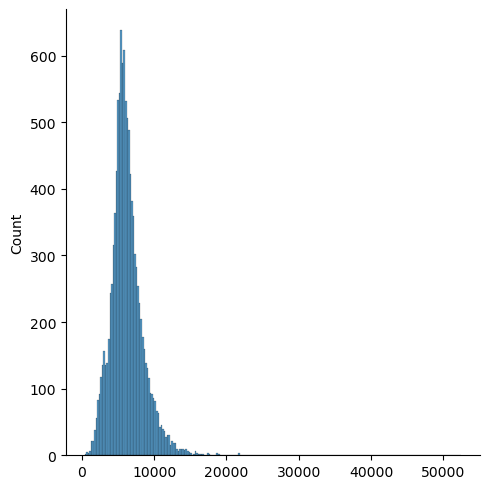

In [184]:
# Plot area distribution

sns.displot(areas)

In [185]:
np.median(areas)

5950.5

## Check expression pattern

In [186]:
# Get assigned reads 
assigned_index = np.argwhere(reads_assignment != 0).flatten()
assigned_bases = bases[assigned_index]
assigned_points = points[assigned_index, :]

In [187]:
selected_genes = ['Slc6a11', 'Olig1']
expr_figure_out_path = os.path.join(expr_out_path, 'figures')
if not os.path.exists(expr_figure_out_path):
    os.mkdir(expr_figure_out_path)
    
for i, gene in enumerate(tqdm(selected_genes)):
    
    curr_index = np.argwhere(assigned_bases == gene).flatten()
    curr_points = assigned_points[curr_index, :]
    n_reads = curr_points.shape[0]

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay, cmap='gray')
    plt.plot(curr_points[:, 0], curr_points[:, 1], '.', color='red', markersize=.5)
    plt.axis('off')
    expr_figure_path = os.path.join(expr_figure_out_path, f"{i+1}.{gene}_{n_reads}.png")
    plt.savefig(expr_figure_path)
    plt.clf()
    plt.close()

 50%|█████     | 1/2 [00:05<00:05,  5.52s/it]

100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


### Create h5ad file

In [188]:
# Create AnnData object 
cell_barcode_names.index = cell_barcode_names.gene
cell_barcode_names = cell_barcode_names.drop('gene', axis=1)
adata = AnnData(X=cell_by_gene, var=cell_barcode_names, obs=current_meta)

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(os.path.join(expr_out_path, f"{date}-{current_sample}.h5ad"))

/home/unix/jiahao/anaconda3/envs/starfinder/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
